In [124]:
from pathlib import Path
from matplotlib.font_manager import fontManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
rng=np.random.default_rng(seed=42)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
# from utils.helper import fn_plot_torch_hist,fn_plot_confusion_matrix
import tensorflow as tf

from sklearn.preprocessing import StandardScaler


ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

In [ ]:
###----------------------
### Some basic parameters
###----------------------

inpDir = Path('..') / '..' / 'input'
outDir = Path('..') / 'output'
modelDir = Path('..') / 'models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
TRAIN_SIZE=454*BATCH_SIZE

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

: 

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

: 

In [ ]:
# Check if all directories are present
outDir.mkdir(parents=True, exist_ok=True)

modelSubDir = modelDir/ subDir
modelSubDir.mkdir(parents=True, exist_ok=True)

: 

In [ ]:
data_df = pd.read_csv(r"D:\dnn_input\fifa_2019.csv")
data_df.shape

(18207, 89)

: 

In [ ]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


: 

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18147 non-null  int64  
 1   ID                        18147 non-null  int64  
 2   Name                      18147 non-null  object 
 3   Age                       18147 non-null  int64  
 4   Photo                     18147 non-null  object 
 5   Nationality               18147 non-null  object 
 6   Flag                      18147 non-null  object 
 7   Overall                   18147 non-null  int64  
 8   Potential                 18147 non-null  int64  
 9   Club                      17918 non-null  object 
 10  Club Logo                 18147 non-null  object 
 11  Value                     18147 non-null  object 
 12  Wage                      18147 non-null  object 
 13  Special                   18147 non-null  int64  
 14  Preferred F

: 

In [125]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Position,18147.0,1.641924,0.910924,0.0,1.0,2.0,2.0,3.0
Finishing,18147.0,45.550229,19.527445,2.0,30.0,49.0,62.0,95.0
HeadingAccuracy,18147.0,52.300766,17.381753,4.0,44.0,56.0,64.0,94.0
ShortPassing,18147.0,58.695432,14.696075,7.0,54.0,62.0,68.0,93.0
Volleys,18147.0,42.912217,17.695900,4.0,30.0,44.0,57.0,90.0
Dribbling,18147.0,55.375158,18.912224,4.0,49.0,61.0,68.0,97.0
Curve,18147.0,47.176283,18.396009,6.0,34.0,48.0,62.0,94.0
FKAccuracy,18147.0,42.866038,17.480034,3.0,31.0,41.0,57.0,94.0
LongPassing,18147.0,52.721386,15.325211,9.0,43.0,56.0,64.0,93.0
BallControl,18147.0,58.374828,16.685643,5.0,54.0,63.0,69.0,96.0


In [126]:
data_df.isna().sum()[data_df.isna().sum() > 0]

Series([], dtype: int64)

In [127]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [128]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [129]:
data_df=data_df[rel_cols]
data_df=data_df[data_df['Position'].notnull()]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [130]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  int8   
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

In [131]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Position,18147.0,1.641924,0.910924,0.0,1.0,2.0,2.0,3.0
Finishing,18147.0,45.550229,19.527445,2.0,30.0,49.0,62.0,95.0
HeadingAccuracy,18147.0,52.300766,17.381753,4.0,44.0,56.0,64.0,94.0
ShortPassing,18147.0,58.695432,14.696075,7.0,54.0,62.0,68.0,93.0
Volleys,18147.0,42.912217,17.695900,4.0,30.0,44.0,57.0,90.0
Dribbling,18147.0,55.375158,18.912224,4.0,49.0,61.0,68.0,97.0
Curve,18147.0,47.176283,18.396009,6.0,34.0,48.0,62.0,94.0
FKAccuracy,18147.0,42.866038,17.480034,3.0,31.0,41.0,57.0,94.0
LongPassing,18147.0,52.721386,15.325211,9.0,43.0,56.0,64.0,93.0
BallControl,18147.0,58.374828,16.685643,5.0,54.0,63.0,69.0,96.0


In [132]:
for col in data_df.columns:
    print(f'Col: {col} -{data_df[col].unique()}')

Col: Position -[3 0 2 1]
Col: Finishing -[95. 94. 87. 13. 82. 84. 72. 93. 60. 11. 91. 76. 42. 65. 90. 14. 67. 89.
 33. 88. 59. 83. 77. 79. 80. 55. 70. 86. 10. 92. 38. 15. 51. 19. 73. 56.
 64. 81. 75. 52. 40. 69. 46. 48. 45. 47. 66. 78. 63. 54. 12. 34. 57. 43.
 37. 20. 41. 85. 18. 25.  9. 71. 44. 27. 21. 74. 31. 68. 39. 62. 29. 61.
 32. 50. 16. 53.  8. 23. 58. 30. 49. 17. 36. 28. 35. 26.  6. 22. 24.  7.
  5.  2.  4.]
Col: HeadingAccuracy -[70. 89. 62. 21. 55. 61. 77. 91. 15. 85. 54. 92. 68. 84. 11. 13. 25. 83.
 59. 76. 56. 52. 48. 79. 87. 75. 10. 80. 81. 73. 86. 35. 74. 58. 72. 51.
 14. 82. 38. 50. 49. 60. 63. 19. 16. 46. 94. 69. 65. 12. 78. 90. 31. 41.
 43. 64. 42. 53. 17. 44. 45. 34. 67. 23. 57. 88. 71. 47. 40. 66. 36. 20.
 39. 93.  8. 18.  7. 37. 32. 24. 33.  9. 30. 22. 28. 27. 29. 26.  5.  6.
  4.]
Col: ShortPassing -[90. 81. 84. 50. 92. 89. 93. 82. 78. 29. 83. 79. 86. 87. 80. 36. 33. 55.
 59. 85. 91. 88. 77. 75. 37. 73. 66. 30. 74. 56. 76. 65. 70. 45. 60. 32.
 68. 71. 15. 39. 44. 7

In [133]:
data_df.isnull().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [134]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0
#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1
#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2
#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

In [135]:
# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [136]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

labels=data_df['Position']
features=data_df.drop('Position',axis=1)
labels.shape,features.shape

((18147,), (18147, 33))

In [137]:
train_df,test_df=train_test_split(data_df,stratify=data_df["Position"],train_size=TRAIN_SIZE,random_state=RANDOM_STATE)
train_df.shape,test_df.shape

((14528, 34), (3619, 34))

## Custom DataSet

In [138]:
class GlobalScaler:
    _instance=None

    def __init__(self):
        if GlobalScaler._instance is not None:
            raise Exception("GlobalScaler is Singleton Class")
        self.scaler=StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance=GlobalScaler()
        return cls._instance


In [139]:
class FifaDS(Dataset):
    globalScaler=GlobalScaler.get_instance() #Protected Variable

    def __init__(self,dataframe,device=device,is_train=True,label_col=None):
        self.df=dataframe
        self.device=device
        self.is_train=is_train
        self.scaler=self.globalScaler.scaler
        self.label_col=label_col
    
        self.labels=self.df[label_col].to_numpy()
        if self.is_train:
            X=self.df.drop(label_col,axis=1)
            self.features=self.scaler.fit_transform(X)
        else:
            X=self.df.drop(label_col,axis=1)
            self.features=self.scaler.transform(X)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,index):
        feature=self.features[index]
        label=self.labels[index]
        # return super().__getitem__(index)

        feature = torch.tensor(feature,dtype=torch.float32,device=self.device)
        label = torch.tensor(label,dtype=torch.int64,device=self.device)
        return feature,label

In [140]:
train_ds = FifaDS(train_df,is_train=True,label_col="Position")
test_ds = FifaDS(test_df,is_train=True,label_col="Position")

In [141]:
train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)


for count,data in enumerate(test_loader):
    feast, lbs =data
    print(f'count:{count} featues:{feast.shape}  labels:{lbs}')

count:0 featues:torch.Size([32, 33])  labels:tensor([2, 1, 2, 3, 2, 1, 3, 2, 1, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 3, 1, 3, 2, 2,
        3, 2, 2, 2, 3, 0, 1, 0])
count:1 featues:torch.Size([32, 33])  labels:tensor([3, 3, 2, 2, 1, 3, 2, 0, 2, 1, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 3,
        1, 3, 2, 1, 1, 1, 0, 0])
count:2 featues:torch.Size([32, 33])  labels:tensor([3, 0, 1, 1, 3, 2, 1, 2, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 3,
        3, 2, 1, 3, 0, 2, 1, 1])
count:3 featues:torch.Size([32, 33])  labels:tensor([3, 2, 2, 1, 2, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,
        2, 0, 2, 1, 2, 0, 1, 2])
count:4 featues:torch.Size([32, 33])  labels:tensor([1, 0, 2, 3, 2, 1, 2, 1, 1, 3, 1, 3, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 3,
        2, 2, 3, 2, 0, 1, 2, 2])
count:5 featues:torch.Size([32, 33])  labels:tensor([2, 1, 2, 2, 1, 0, 2, 3, 1, 2, 3, 1, 2, 1, 1, 3, 1, 2, 1, 2, 1, 2, 0, 1,
        2, 3, 2, 2, 1, 1, 2, 0])
count:6 featues:torch.Size([32, 33])  labels:tensor(

## MOdel Creation

In [142]:
class Model(nn.Module):

    def __init__(self,input_dim):
        super().__init__()
        dim_1 = 66

        self.layer1 = nn.Linear(input_dim,dim_1)
        self.activ1 = nn.ReLU()                 ##  output 66
        
        dim_2 = 33
        self.layer2 = nn.Linear(dim_1,dim_2)
        self.activ2 = nn.ReLU()                 ##  output 33

        dim_3 = 16
        self.layer3 = nn.Linear(dim_2,dim_3)
        self.activ3 = nn.ReLU()                 ##  output 16

        dim_4 = 8
        self.layer4 = nn.Linear(dim_3,dim_4)
        self.activ4 = nn.ReLU()                 ##  output 8

        output_dim = 4
        self.layer5 = nn.Linear(dim_4,output_dim)  ## Output 4
        # self.activ5 = nn.LogSigmoid(dim =1)

    def forward(self,x):
        x = self.activ1(self.layer1(x))
        x = self.activ2(self.layer2(x))
        x = self.activ3(self.layer3(x))
        x = self.activ4(self.layer4(x))
        x = self.layer5(x)
        return x

model =Model(input_dim=33).to(device)

In [143]:
from torchinfo import summary


summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            2,244
├─ReLU: 1-2                              --
├─Linear: 1-3                            2,211
├─ReLU: 1-4                              --
├─Linear: 1-5                            544
├─ReLU: 1-6                              --
├─Linear: 1-7                            136
├─ReLU: 1-8                              --
├─Linear: 1-9                            36
Total params: 5,171
Trainable params: 5,171
Non-trainable params: 0

In [144]:
print(model)

Model(
  (layer1): Linear(in_features=33, out_features=66, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=66, out_features=33, bias=True)
  (activ2): ReLU()
  (layer3): Linear(in_features=33, out_features=16, bias=True)
  (activ3): ReLU()
  (layer4): Linear(in_features=16, out_features=8, bias=True)
  (activ4): ReLU()
  (layer5): Linear(in_features=8, out_features=4, bias=True)
)


In [145]:
from cProfile import label


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=ALPHA)

loss,tloss,acc,tacc,n_epoch=[],[],[],[],[]

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    ## Train
    for i, data in enumerate(train_loader):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        pred = torch.argmax(outputs,dim=1)
        
        batch_loss = loss_fn(outputs,labels)
        batch_acc = accuracy_score(labels.cpu().numpy(),pred.cpu().numpy())
        batch_loss.backward()
        optimizer.step()
        
        train_loss+=batch_loss.item()*inputs.size(0)
        train_acc+=batch_acc*inputs.size(0)
    
    train_loss=train_loss/len(train_ds)
    loss.append(train_loss)
    
    train_acc = train_acc/len(train_ds)
    acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        
        ## Test
        for i, data in enumerate(test_loader):
            inputs,labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            pred = torch.argmax(outputs,dim=1)
            
            batch_loss = loss_fn(outputs,labels)
            batch_acc = accuracy_score(labels.cpu().numpy(),pred.cpu().numpy())
            
            
            test_loss+=batch_loss.item()*inputs.size(0)
            test_acc+=batch_acc*inputs.size(0)
        
        test_loss = test_loss/len(test_ds)
        test_acc = test_acc/len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)

    n_epoch.append(epoch)
    if epoch%10==0:
        print(f"Epoch:{epoch}|Loss:{train_loss:.4f}-Test_loss{test_loss:.4f} | Acc:{train_acc:.4f}-test_acc{test_acc:.4f}")





Epoch:0|Loss:0.5378-Test_loss0.3235 | Acc:0.7622-test_acc0.8632
Epoch:10|Loss:0.2719-Test_loss0.3000 | Acc:0.8895-test_acc0.8770
Epoch:20|Loss:0.2537-Test_loss0.3011 | Acc:0.8960-test_acc0.8754
Epoch:30|Loss:0.2379-Test_loss0.3121 | Acc:0.9034-test_acc0.8746
Epoch:40|Loss:0.2224-Test_loss0.3243 | Acc:0.9109-test_acc0.8723
Epoch:50|Loss:0.2040-Test_loss0.3457 | Acc:0.9179-test_acc0.8621
Epoch:60|Loss:0.1867-Test_loss0.3724 | Acc:0.9273-test_acc0.8646
Epoch:70|Loss:0.1689-Test_loss0.4138 | Acc:0.9350-test_acc0.8569
Epoch:80|Loss:0.1528-Test_loss0.4509 | Acc:0.9401-test_acc0.8558
Epoch:90|Loss:0.1367-Test_loss0.5464 | Acc:0.9471-test_acc0.8563


In [146]:
len(loss),len(tloss),len(acc),len(tacc),len(n_epoch)

(100, 100, 100, 100, 100)

In [147]:
result_df=pd.DataFrame(data={'loss':loss,"val_loss":tloss,"accuracy":acc,'val_accuracy':tacc,'epoch':n_epoch})

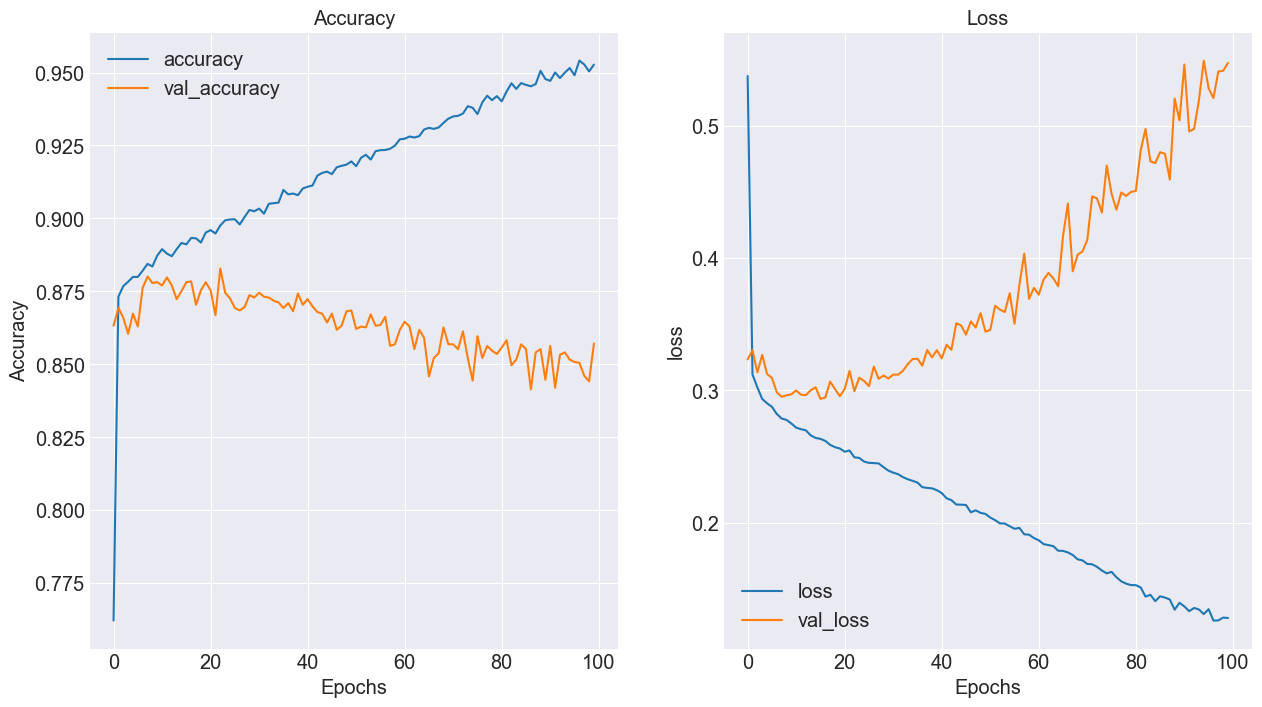

In [148]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].plot(result_df.epoch,result_df['accuracy'],label='accuracy')
ax[0].plot(result_df.epoch,result_df['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(result_df.epoch,result_df['loss'],label='loss')
ax[1].plot(result_df.epoch,result_df['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].legend()

plt.show()

In [161]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tf'